In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import yfinance as yf
from tqdm.notebook import tqdm

# one-time download of nltk stopwords and wordnet resources required
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.base import clone, BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from scipy.sparse import hstack
from scipy import sparse

#!pip install scikeras
from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.layers import Conv1D, LSTM, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Let pandas handle date parsing internally — it's optimized and faster
news_df = pd.read_csv('analyst_ratings_processed.csv', parse_dates=['date']).dropna()
news_df['date'] = pd.to_datetime(news_df['date'], utc=True) # removed .dt.date
news_df['date'] = news_df['date'].dt.tz_localize(None) # new line of code to remove tz infor

prices_df = pd.read_csv('prices-split-adjusted.csv', parse_dates=['date']).dropna()
prices_df['date'] = pd.to_datetime(prices_df['date']) # changed to get pd.Timestamp

news_df.head()

,Unnamed: 0,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 14:30:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 14:45:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 08:30:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 16:45:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 15:38:00,A


In [4]:
# Clean column names
news_df = news_df.rename(columns={'title': 'headline', 'stock': 'ticker'})
prices_df = prices_df.rename(columns={'symbol': 'ticker'})

# normalize dates to remove time & timezone info
news_1day = news_df.copy()
news_1day['date'] = pd.to_datetime(news_1day['date'], utc=True)
news_1day['date'] = news_1day['date'].dt.tz_localize(None).dt.normalize()

# ensure price dates are also normalized
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices_df['date'] = prices_df['date'].dt.normalize()

# limit news to same range as prices
min_price_date = prices_df['date'].min()
max_price_date = prices_df['date'].max()

news_1day = news_1day[
    (news_1day['date'] >= min_price_date) &
    (news_1day['date'] <= max_price_date)
]

# get previous trading day per ticker
# sort and shift to get the previous trading day for each ticker
prices_1day = prices_df[['ticker', 'date', 'close']].copy()
prices_1day = prices_1day.sort_values(['ticker', 'date'])
prices_1day['prev_trading_date'] = prices_1day.groupby('ticker')['date'].shift(1)

# merge with news from the previous trading day
merged_with_news = pd.merge(
    prices_1day,
    news_1day[['ticker', 'date', 'headline']],
    left_on=['ticker', 'prev_trading_date'],
    right_on=['ticker', 'date'],
    how='left'
)

# rename to avoid confusion
news_with_price = merged_with_news.rename(columns={
    'date_x': 'date',            # trading date
    'date_y': 'headline_date'    # date of the news
})

In [5]:
# aggregate headlines per (ticker, trading day)
headline_agg = news_with_price.groupby(['ticker', 'date'])['headline'] \
    .apply(lambda x: " ".join(x.dropna())).reset_index()

# merge aggregated headlines back with prices_1day
merged_1day = pd.merge(
    prices_1day,
    headline_agg,
    on=['ticker', 'date'],
    how='left'
).rename(columns={'headline': 'headlines_prev_day'})

# add target column: UP or DOWN
# get previous day close for each ticker
merged_1day = merged_1day.sort_values(['ticker', 'date'])
merged_1day['prev_close'] = merged_1day.groupby('ticker')['close'].shift(1)

# create target column
merged_1day['target'] = np.where(
    merged_1day['close'] > merged_1day['prev_close'],
    'UP', 'DOWN'
)

# reorder columns for clarity
merged_1day = merged_1day[['ticker', 'date', 'prev_trading_date', 'prev_close', 'headlines_prev_day', 'close', 'target']]

# drop rows without headlines
merged_1day = merged_1day[
    merged_1day['headlines_prev_day'].fillna('').str.strip() != ''
]

# reset index
merged_1day.reset_index(drop=True, inplace=True)

In [6]:
# clean and lemmatize headlines

# pre-process text information

# Setup
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# Cleaning function
def clean(doc):
    # Lowercase and remove stopwords
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    # Remove punctuation
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    # Lemmatize words
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

merged_1day['headlines_prev_day_clean'] = merged_1day['headlines_prev_day'].apply(clean)

In [7]:
merged_1day.head()

,ticker,date,prev_trading_date,prev_close,headlines_prev_day,close,target,headlines_prev_day_clean
0,A,2010-02-16,2010-02-12,21.444921,Agilent Technologies (A) Reports 23% Profit Ri...,21.638054,UP,agilent technology a report 23 profit rise ben...
1,A,2010-02-18,2010-02-17,21.909872,The Google Buzz Guide for the Enterprise (with...,22.160229,UP,google buzz guide enterprise with buzz matrix
2,A,2010-03-11,2010-03-10,24.077253,BRKR Buys VARI’s Assets; Deal To Be Accretive ...,24.020029,DOWN,brkr buy vari’s asset deal accretive 201011
3,A,2010-03-12,2010-03-11,24.020029,The Health Care Reform Bill: Welcome To The Bi...,23.905579,DOWN,health care reform bill welcome biggest tax in...
4,A,2010-03-25,2010-03-24,24.248926,IBD Takedown of the Health Insurance Law,24.713877,UP,ibd takedown health insurance law


### Train-Val-Test Split

In [8]:
# Separate data into train (60%), val (20%), and test (20%) sets
# temporal split for train-validation-test sets

# Ensure 'date' column is in datetime format
merged_1day['date'] = pd.to_datetime(merged_1day['date'])

# Sort the dataframe by date
merged_1day = merged_1day.sort_values(by='date').reset_index(drop=True)

# Compute split indices
n = len(merged_1day)
train_end = int(0.6 * n)
valid_end = int(0.8 * n)

# Split the data
train_set_time = merged_1day.iloc[:train_end]
valid_set_time = merged_1day.iloc[train_end:valid_end]
test_set_time  = merged_1day.iloc[valid_end:]

In [9]:
# confirm date ranges
print("Train range:", train_set_time['date'].min(), "to", train_set_time['date'].max())
print("Validation range:", valid_set_time['date'].min(), "to", valid_set_time['date'].max())
print("Test range:", test_set_time['date'].min(), "to", test_set_time['date'].max())

Train range: 2010-01-05 00:00:00 to 2014-04-16 00:00:00
Validation range: 2014-04-16 00:00:00 to 2015-09-18 00:00:00
Test range: 2015-09-18 00:00:00 to 2016-12-30 00:00:00


### Build and Tune Random Forest

In [10]:
# preserve indices for retrieval of headline and price data after model evaluation
train_indices = train_set_time.index
valid_indices = valid_set_time.index
test_indices = test_set_time.index

# separate X and y
X_train_time = train_set_time['headlines_prev_day_clean']
X_val_time = valid_set_time['headlines_prev_day_clean']
X_test_time = test_set_time['headlines_prev_day_clean']
y_train_time = train_set_time['target'].map({'DOWN': 0, 'UP': 1}).astype(int)
y_val_time = valid_set_time['target'].map({'DOWN': 0, 'UP': 1}).astype(int)
y_test_time = test_set_time['target'].map({'DOWN': 0, 'UP': 1}).astype(int)

In [11]:
# build pipeline
rf_time_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

# parameter grid to search
param_grid = {
    'tfidf__max_features': [5000],
    'rf__n_estimators': [400],
    'rf__max_depth': [None]
}


# time series splitting is needed for temporal data
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# GridSearch
rf_grid = GridSearchCV(
    rf_time_pipeline,
    param_grid,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)

In [12]:
# fit on the training set
start = time.time()
rf_grid.fit(X_train_time, y_train_time)
train_time = time.time() - start
print('Time required to tune model (min): {:.1f}'.format(train_time/60))

# best model
print(f"Best RF Parameters: {rf_grid.best_params_}")
print(f"Best RF CV Accuracy: {rf_grid.best_score_:.4f}")

# get the best pipeline
best_rf_model = rf_grid.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END rf__max_depth=None, rf__n_estimators=400, tfidf__max_features=5000;, score=0.499 total time= 1.1min
[CV 2/5] END rf__max_depth=None, rf__n_estimators=400, tfidf__max_features=5000;, score=0.504 total time= 2.6min
[CV 3/5] END rf__max_depth=None, rf__n_estimators=400, tfidf__max_features=5000;, score=0.503 total time= 4.3min
[CV 4/5] END rf__max_depth=None, rf__n_estimators=400, tfidf__max_features=5000;, score=0.502 total time= 6.3min
[CV 5/5] END rf__max_depth=None, rf__n_estimators=400, tfidf__max_features=5000;, score=0.507 total time= 8.3min
Time required to tune model (min): 17.0
Best RF Parameters: {'rf__max_depth': None, 'rf__n_estimators': 400, 'tfidf__max_features': 5000}
Best RF CV Accuracy: 0.5030


In [13]:
rf_probs = best_rf_model.predict_proba(X_val_time)
rf_y_proba = rf_probs[:, 1]
rf_y_pred = (rf_y_proba > 0.5).astype("int32")
rf_acc = accuracy_score(y_val_time, rf_y_pred)

Validation Accuracy: 0.5043


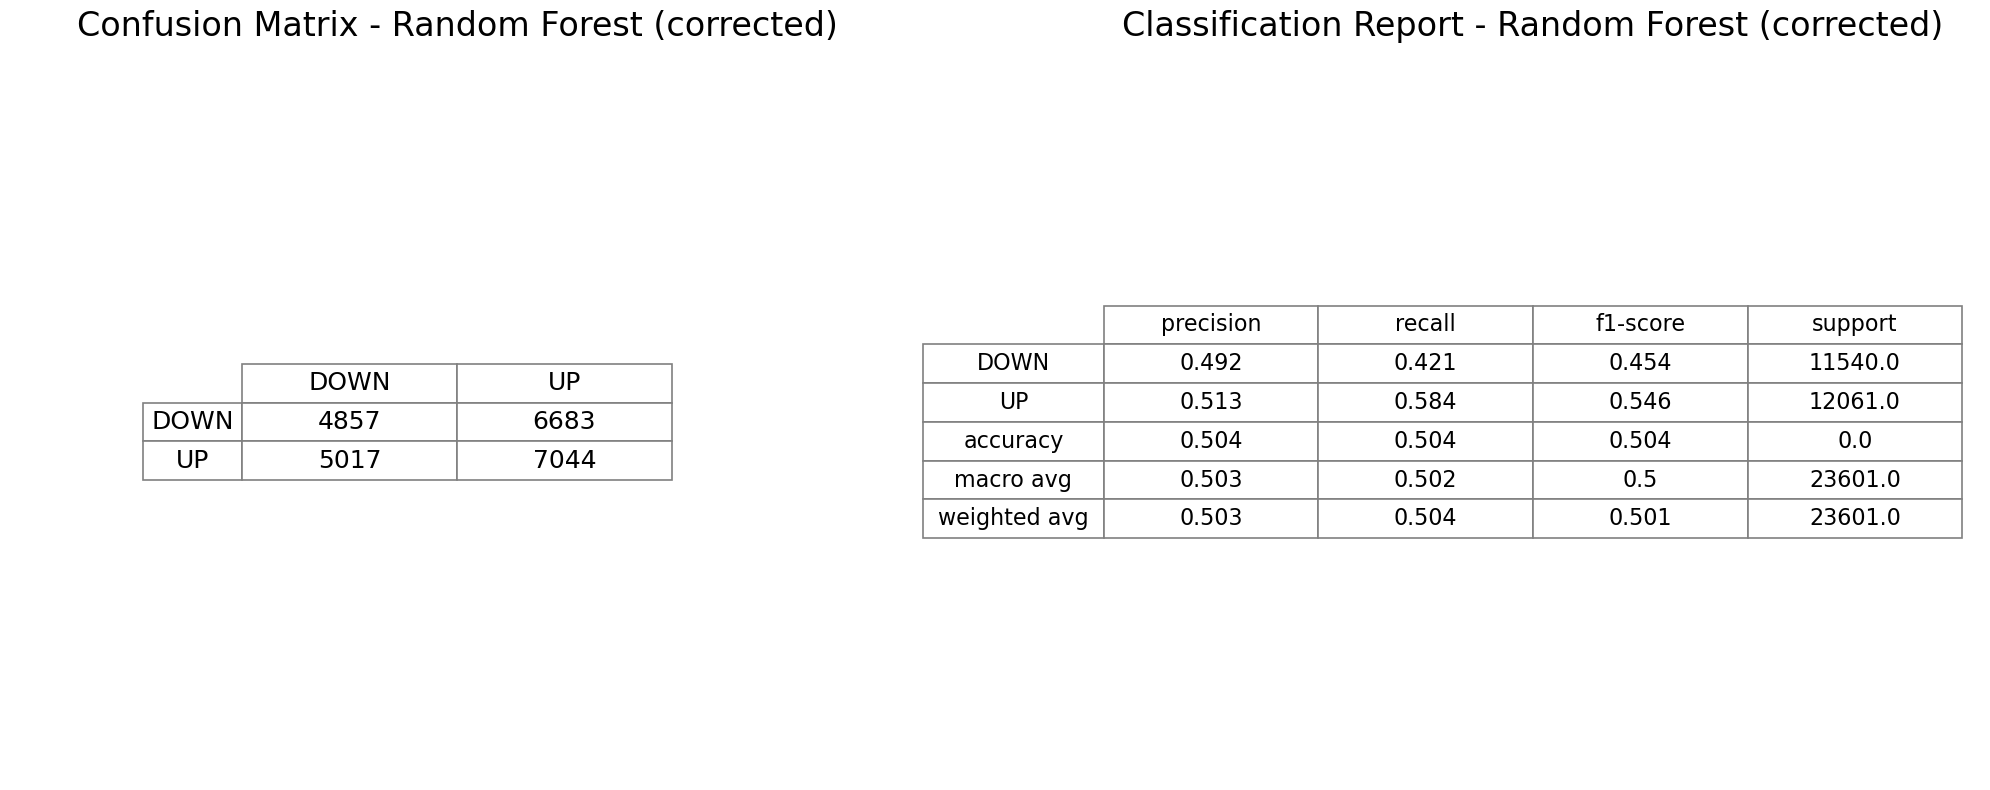

In [14]:
# display validation accuracy
print(f"Validation Accuracy: {rf_acc:.4f}")

# confusion matrix
rf_cm = confusion_matrix(y_val_time, rf_y_pred)
labels = sorted(merged_1day['target'].unique())
rf_cm_df = pd.DataFrame(rf_cm, index=labels, columns=labels)

# classification report
rf_cr = classification_report(y_val_time, rf_y_pred, output_dict=True)
rf_cr_df = pd.DataFrame(rf_cr).transpose()
for col in ['precision', 'recall', 'f1-score']:
    rf_cr_df[col] = rf_cr_df[col].round(3)
rf_cr_df['support'] = rf_cr_df['support'].astype(int)
rf_cr_df.rename(index={'0': 'DOWN', '1': 'UP'}, inplace=True)

# plot confusion matrix and classification report
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# confusion matrix on left
axes[0].axis('off')
table1 = axes[0].table(cellText=rf_cm_df.values,
                       rowLabels=rf_cm_df.index,
                       colLabels=rf_cm_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(rf_cm_df.columns)
)

table1.auto_set_font_size(False)
table1.set_fontsize(18)
table1.scale(1.2, 2.0)
for key, cell in table1.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[0].set_title('Confusion Matrix - Random Forest (corrected)', fontsize=24, pad=20)

# classification report on right
axes[1].axis('off')

table2 = axes[1].table(cellText=rf_cr_df.values,
                       rowLabels=rf_cr_df.index,
                       colLabels=rf_cr_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(rf_cr_df.columns)
)

table2.auto_set_font_size(False)
table2.set_fontsize(16)
table2.scale(1.2, 2.0)
for key, cell in table2.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[1].set_title('Classification Report - Random Forest (corrected)', fontsize=24, pad=20)

plt.tight_layout()
#plt.savefig('new_rf_confusion_and_classification_report.png', dpi=300,  bbox_inches='tight')
plt.show()

In [15]:
# Assess cumulative returns by picking most likely UPs daily

# create copy of merged_1day_val with results
rf_val_results = valid_set_time.copy()
rf_val_results['prob_up'] = rf_y_proba

# add daily % return column
rf_val_results['daily_return_pct'] = ((rf_val_results['close'] - rf_val_results['prev_close']) / rf_val_results['prev_close']) * 100

# sort by date and predicted probability
rf_sorted_preds = rf_val_results.sort_values(by=['date', 'prob_up'], ascending=[True, False])

# apply threshold filter (keep only confident picks)
rf_sorted_preds = rf_sorted_preds[rf_sorted_preds['prob_up'] >= 0.6]

# get top 5 (or fewer) picks per day
rf_top5_daily = rf_sorted_preds.groupby('date').head(5)

# calculate average return for the top picks per day
rf_daily_avg_return = rf_top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
rf_daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)

# compute cumulative return (compounded over time)
rf_daily_avg_return['cumulative_return_pct'] = (1 + rf_daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
rf_daily_avg_return['cumulative_return_pct'] *= 100  # back to percent

In [ ]:
# Build S&P 500 comparison

# get S&P 500 data for the same date range
start_date_val = rf_daily_avg_return['date'].min()
end_date_val = rf_daily_avg_return['date'].max()
sp500_val = yf.download("^GSPC", start=start_date_val, end=end_date_val)

# ensure index is datetime and trimmed to match your data
sp500_val = sp500_val[['Open', 'Close']]
sp500_val = sp500_val.reset_index()  # brings 'Date' into a column
sp500_val.rename(columns={'Date': 'date'}, inplace=True)  # match column name with daily_avg_return

# prepare the S&P 500 daily % returns and cumulative return
sp500_val['daily_return_pct'] = ((sp500_val['Close'] - sp500_val['Open']) / sp500_val['Open']) * 100
sp500_val['sp500_cum_return_pct'] = (1 + sp500_val['daily_return_pct'] / 100).cumprod() - 1
sp500_val['sp500_cum_return_pct'] *= 100

# ensure sp500 'date' is datetime type
sp500_val['date'] = pd.to_datetime(sp500_val['date'])

# flatten sp500 multi-level columns (if any)
sp500_val.columns = [col if isinstance(col, str) else col[0] for col in sp500.columns]

# merge with your returns
rf_comparison = rf_daily_avg_return.merge(
    sp500_val[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

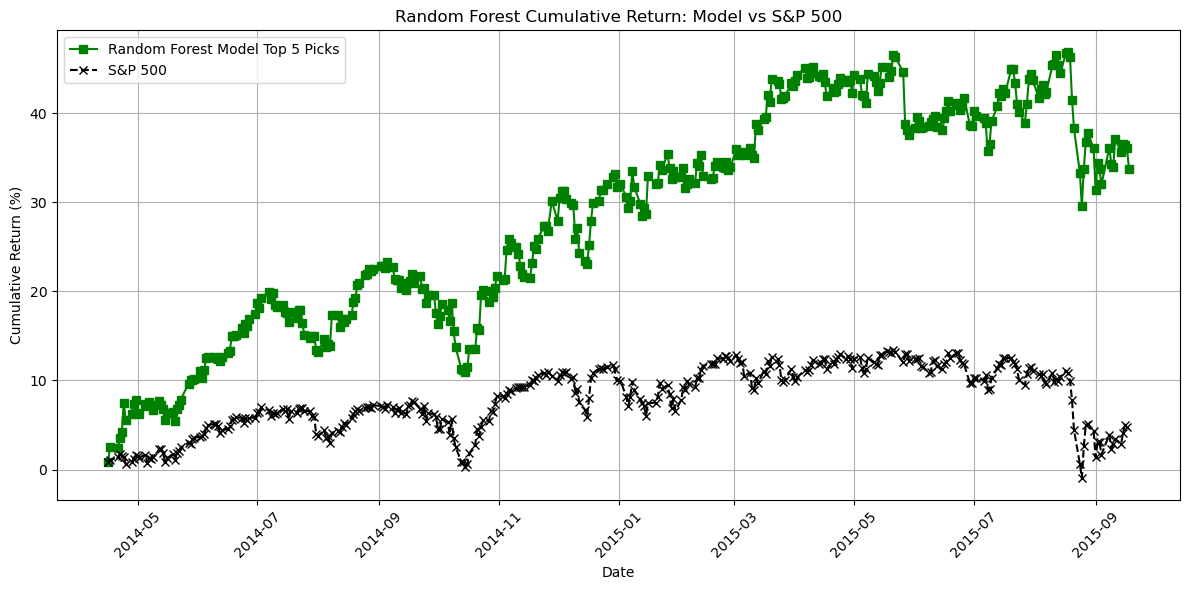

In [503]:
# plot rf model returns and S&P 500 returns
plt.figure(figsize=(12, 6))
plt.plot(
    rf_comparison['date'], rf_comparison['cumulative_return_pct'],
    label='Random Forest Model Top 5 Picks',
    color='green', marker='s', linestyle='-')
plt.plot(
    rf_comparison['date'], rf_comparison['sp500_cum_return_pct'],
    label='S&P 500',
    color='black', marker='x', linestyle='--')

plt.title("Random Forest Cumulative Return: Model vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('time_corrected_rf_cumulative_return_comparison.png', format='png') 
plt.show()

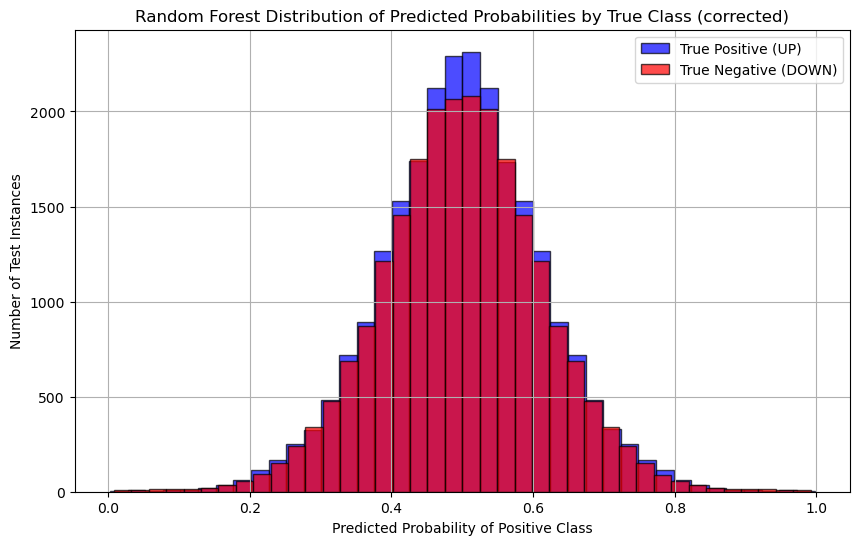

In [504]:
# plot distributions of predictions by true class
y_val_array = np.array(y_val_time)

# Then split the predicted probabilities based on true labels
probs_positive = rf_probs[y_val_array == 1]
probs_negative = rf_probs[y_val_array == 0]

probs_positive = probs_positive.flatten()
probs_negative = probs_negative.flatten()

# Now plot
plt.figure(figsize=(10, 6))
plt.hist(probs_positive, bins=40, alpha=0.7, label='True Positive (UP)', color='blue', edgecolor='k')
plt.hist(probs_negative, bins=40, alpha=0.7, label='True Negative (DOWN)', color='red', edgecolor='k')

plt.title('Random Forest Distribution of Predicted Probabilities by True Class (corrected)')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Number of Test Instances')
plt.legend()
plt.grid(True)
#plt.savefig('time_corrected_rf_prob_distribution_versus_true_class.png', format='png') 
plt.show()

In [483]:
# Hybrid CNN-LTSM Model

# --- Custom transformer to tokenize and pad sequences ---
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, num_words=10000, max_len=40):
        self.num_words = num_words
        self.max_len = max_len
        self.tokenizer = None

    def fit(self, X, y=None):
        self.tokenizer = Tokenizer(num_words=self.num_words, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(X)
        return self

    def transform(self, X):
        sequences = self.tokenizer.texts_to_sequences(X)
        padded = pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')
        return padded


def build_cnn_lstm_model(vocab_size=10000, embedding_dim=100, input_length=40, l2_reg=0.01, dropout_rate=0.5):
    model = Sequential()
    model.add(Input(shape=(input_length,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [484]:
# hybrid cnn-lstm pipeline
cnn_lstm_pipeline = Pipeline([
    ('preprocess', TextPreprocessor(num_words=10000, max_len=40)),
    ('clf', KerasClassifier(
        model=build_cnn_lstm_model,
        model__vocab_size=10000,
        model__embedding_dim=100,
        model__input_length=40,
        model__l2_reg=0.01,
        model__dropout_rate=0.5,
        epochs=10,
        batch_size=32,
        verbose=0,
        shuffle=False,
        random_state=42
    ))
])

# gridsearch setup
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'clf__batch_size': [32],
    'clf__epochs': [10],
    'clf__model__l2_reg': [0.01],
    'clf__model__dropout_rate': [0.3],
}

# define gridsearch
grid_search = GridSearchCV(
    cnn_lstm_pipeline,
    param_grid,
    cv=tscv,
    scoring='accuracy',
    verbose=3
)

In [485]:
# fit on training set
start = time.time()
grid_search.fit(X_train_time, y_train_time)
train_time = time.time() - start
print(f"Training time (min): {train_time / 60:.1f}")

print("Best Params:", grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

# get the best pipeline
best_hybrid_cnn_lstm_model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END clf__batch_size=32, clf__epochs=10, clf__model__dropout_rate=0.3, clf__model__l2_reg=0.01;, score=0.501 total time=  29.0s
[CV 2/5] END clf__batch_size=32, clf__epochs=10, clf__model__dropout_rate=0.3, clf__model__l2_reg=0.01;, score=0.497 total time=  53.5s
[CV 3/5] END clf__batch_size=32, clf__epochs=10, clf__model__dropout_rate=0.3, clf__model__l2_reg=0.01;, score=0.512 total time= 1.3min
[CV 4/5] END clf__batch_size=32, clf__epochs=10, clf__model__dropout_rate=0.3, clf__model__l2_reg=0.01;, score=0.499 total time= 1.8min
[CV 5/5] END clf__batch_size=32, clf__epochs=10, clf__model__dropout_rate=0.3, clf__model__l2_reg=0.01;, score=0.500 total time= 2.3min
Training time (min): 9.5
Best Params: {'clf__batch_size': 32, 'clf__epochs': 10, 'clf__model__dropout_rate': 0.3, 'clf__model__l2_reg': 0.01}
Best CV Accuracy: 0.5018


In [488]:
cnn_probs = best_hybrid_cnn_lstm_model.predict_proba(X_val_time)
cnn_y_proba = cnn_probs[:, 1]
cnn_y_pred = (cnn_y_proba > 0.5).astype("int32")
cnn_acc = accuracy_score(y_val_time, cnn_y_pred)

Validation Accuracy: 0.5047


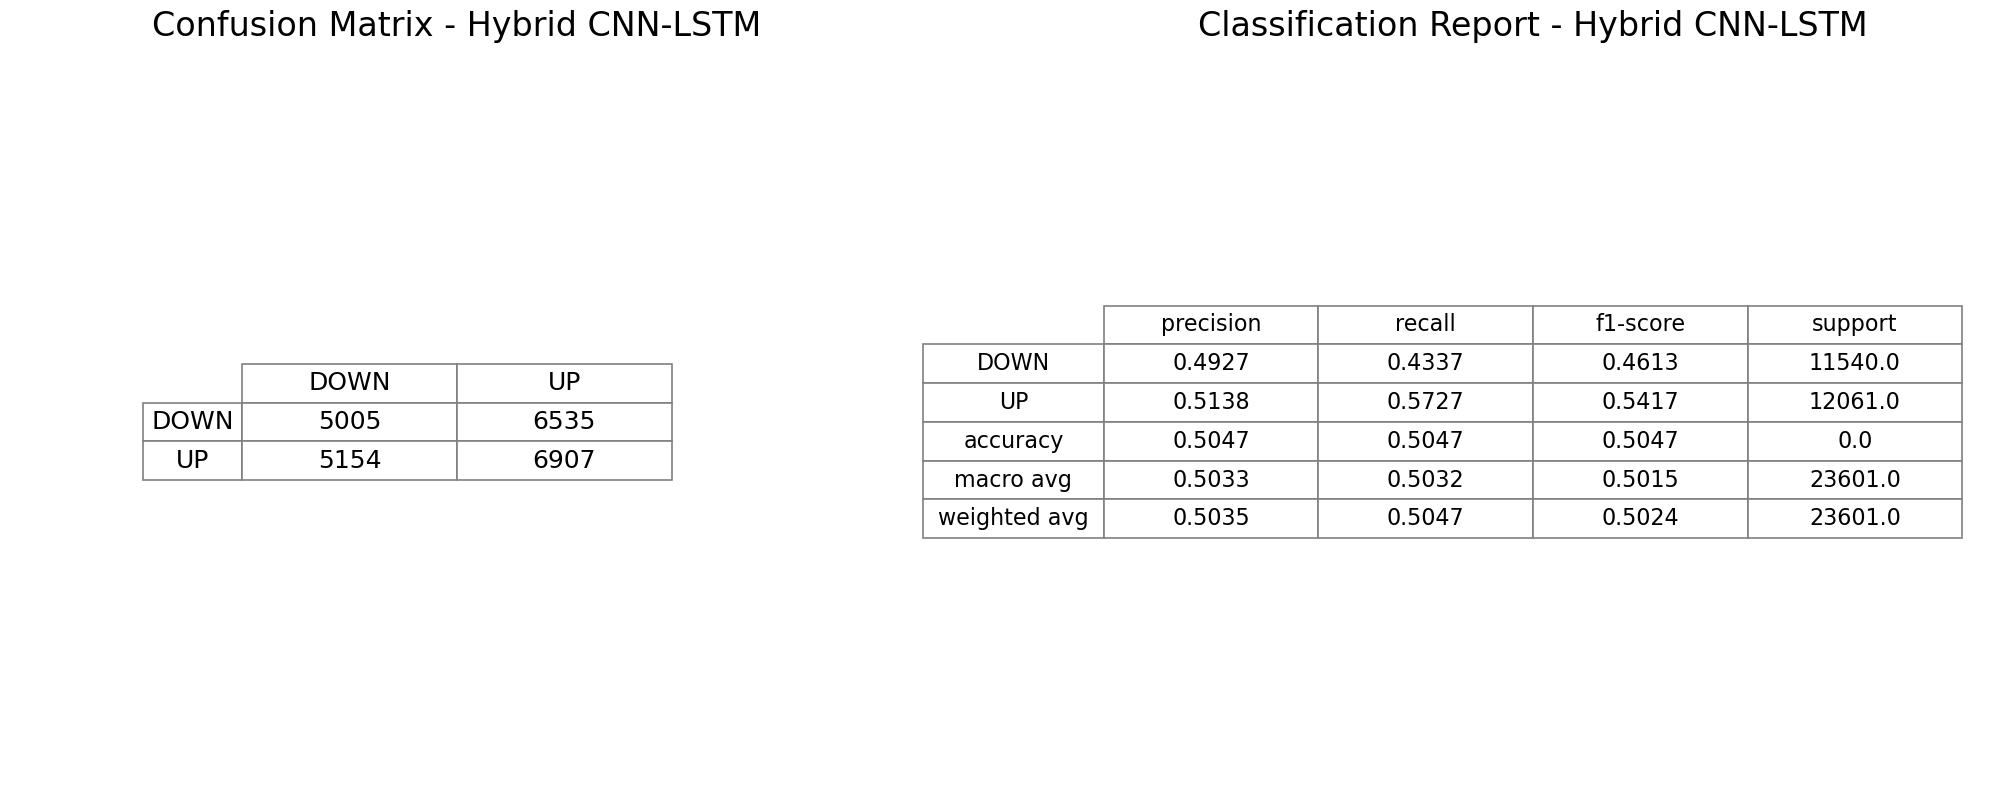

In [494]:
# display validation accuracy
print(f"Validation Accuracy: {cnn_acc:.4f}")

# confusion matrix
cnn_cm = confusion_matrix(y_val_time, cnn_y_pred)
labels = sorted(merged_1day['target'].unique())
cnn_cm_df = pd.DataFrame(cnn_cm, index=labels, columns=labels)

# classification report
cnn_cr = classification_report(y_val_time, cnn_y_pred, output_dict=True)
cnn_cr_df = pd.DataFrame(cnn_cr).transpose()
for col in ['precision', 'recall', 'f1-score']:
    cnn_cr_df[col] = cnn_cr_df[col].round(4)
cnn_cr_df['support'] = cnn_cr_df['support'].astype(int)
cnn_cr_df.rename(index={'0': 'DOWN', '1': 'UP'}, inplace=True)

# plot confusion matrix and classification report
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# confusion matrix on left
axes[0].axis('off')
table1 = axes[0].table(cellText=cnn_cm_df.values,
                       rowLabels=cnn_cm_df.index,
                       colLabels=cnn_cm_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(cnn_cm_df.columns)
)

table1.auto_set_font_size(False)
table1.set_fontsize(18)
table1.scale(1.2, 2.0)
for key, cell in table1.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[0].set_title('Confusion Matrix - Hybrid CNN-LSTM', fontsize=24, pad=20)

# classification report on right
axes[1].axis('off')

table2 = axes[1].table(cellText=cnn_cr_df.values,
                       rowLabels=cnn_cr_df.index,
                       colLabels=cnn_cr_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(cnn_cr_df.columns)
)

table2.auto_set_font_size(False)
table2.set_fontsize(16)
table2.scale(1.2, 2.0)
for key, cell in table2.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[1].set_title('Classification Report - Hybrid CNN-LSTM', fontsize=24, pad=20)

plt.tight_layout()
#plt.savefig('time_corrected_cnn_lstm_confusion_and_classification_report.png', dpi=300,  bbox_inches='tight')
plt.show()

In [490]:
# Assess cumulative returns by picking most likely UPs daily

# create copy of merged_1day_val with results
cnn_val_results = valid_set_time.copy()
cnn_val_results['prob_up'] = cnn_y_proba

# add daily % return column
cnn_val_results['daily_return_pct'] = ((cnn_val_results['close'] - cnn_val_results['prev_close']) / cnn_val_results['prev_close']) * 100

# sort by date and predicted probability
cnn_sorted_preds = cnn_val_results.sort_values(by=['date', 'prob_up'], ascending=[True, False])

# apply threshold filter (keep only confident picks)
cnn_sorted_preds = cnn_sorted_preds[cnn_sorted_preds['prob_up'] >= 0.6]

# get top 5 (or fewer) picks per day
cnn_top5_daily = cnn_sorted_preds.groupby('date').head(5)

# calculate average return for the top picks per day
cnn_daily_avg_return = cnn_top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
cnn_daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)

# compute cumulative return (compounded over time)
cnn_daily_avg_return['cumulative_return_pct'] = (1 + cnn_daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
cnn_daily_avg_return['cumulative_return_pct'] *= 100  # back to percent

In [491]:
# merge with model returns
cnn_comparison = cnn_daily_avg_return.merge(
    sp500_val[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

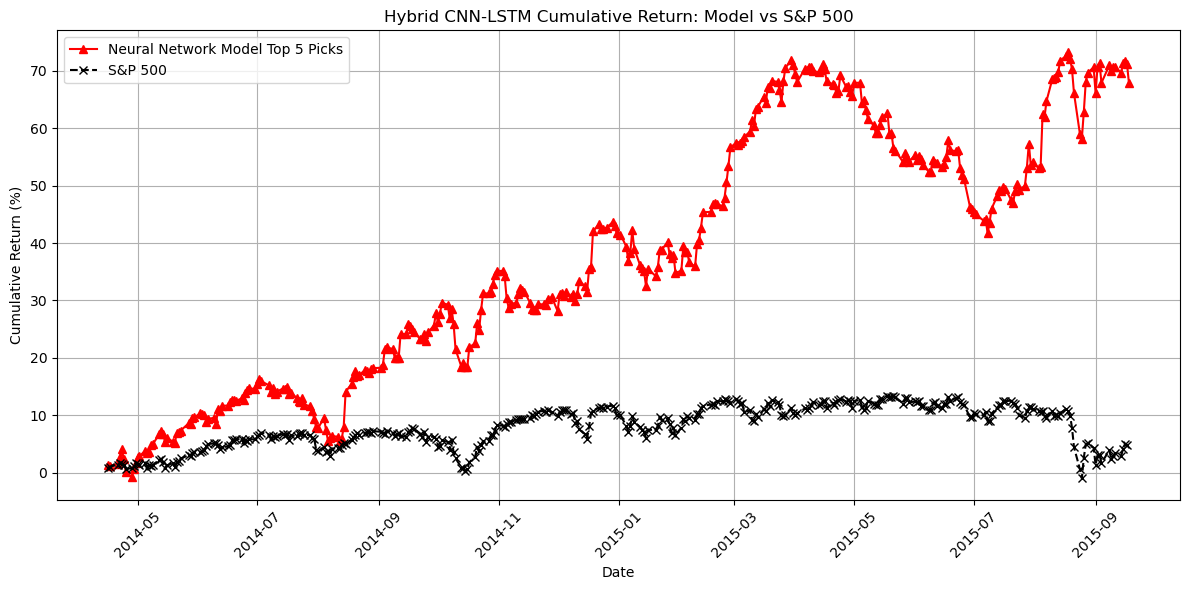

In [505]:
# plot nn model returns and S&P 500 returns
plt.figure(figsize=(12, 6))
plt.plot(cnn_comparison['date'], cnn_comparison['cumulative_return_pct'],
         label='Neural Network Model Top 5 Picks',
         color='red', marker='^', linestyle='-')
plt.plot(cnn_comparison['date'], cnn_comparison['sp500_cum_return_pct'],
         label='S&P 500',
         color='black', marker='x', linestyle='--')

plt.title("Hybrid CNN-LSTM Cumulative Return: Model vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('time_corrected_cnn_lstm_cumulative_return_comparison.png', format='png') 
plt.show()

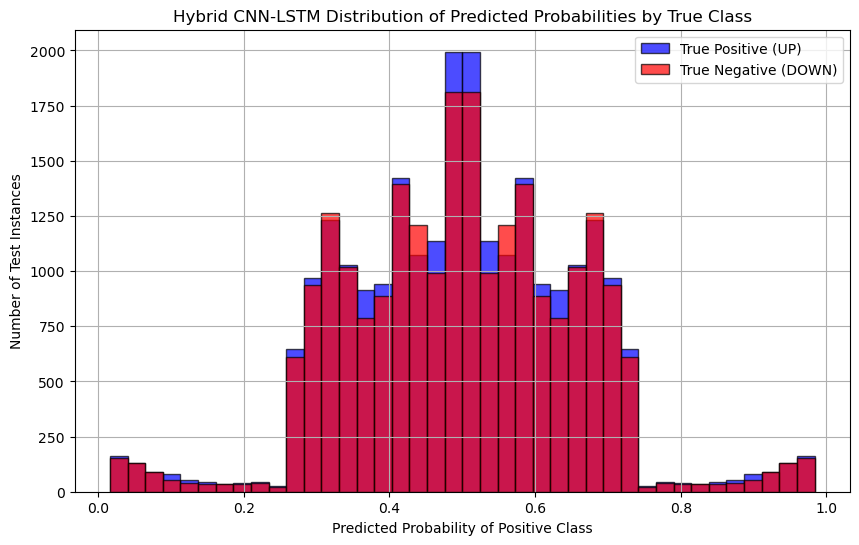

In [506]:
# plot distributions of predictions by true class

# split the predicted probabilities based on true labels
cnn_probs_positive = cnn_probs[y_val_array == 1]
cnn_probs_negative = cnn_probs[y_val_array == 0]

cnn_probs_positive = cnn_probs_positive.flatten()
cnn_probs_negative = cnn_probs_negative.flatten()

# Now plot
plt.figure(figsize=(10, 6))
plt.hist(cnn_probs_positive, bins=40, alpha=0.7, label='True Positive (UP)', color='blue', edgecolor='k')
plt.hist(cnn_probs_negative, bins=40, alpha=0.7, label='True Negative (DOWN)', color='red', edgecolor='k')

plt.title('Hybrid CNN-LSTM Distribution of Predicted Probabilities by True Class')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Number of Test Instances')
plt.legend()
plt.grid(True)
#plt.savefig('time_corrected_cnn_lstm_prob_distribution_versus_true_class.png', format='png') 
plt.show()

## Stacked Model with Time-corrected data

In [507]:
# merge train and val sets
X_train_time_full = pd.concat([X_train_time, X_val_time], axis=0)
y_train_time_full = pd.concat([y_train_time, y_val_time], axis=0)

# prepare base model clones (to avoid leakage)
base_model_1 = clone(best_rf_model)
base_model_2 = clone(best_hybrid_cnn_lstm_model)

# initialize out-of-fold prediction arrays
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
oof_preds_rf = np.zeros(len(X_train_time_full))
oof_preds_cnn = np.zeros(len(X_train_time_full))

# loop through folds
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_time_full, y_train_time_full)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    # split data
    X_tr, X_val_fold = X_train_time_full.iloc[train_idx], X_train_time_full.iloc[val_idx]
    y_tr, y_val_fold = y_train_time_full.iloc[train_idx], y_train_time_full.iloc[val_idx]
    
    # train both base models
    model_rf = clone(base_model_1)
    model_cnn = clone(base_model_2)

    model_rf.fit(X_tr, y_tr)
    model_cnn.fit(X_tr, y_tr, clf__verbose=0)

    # get validation predictions
    oof_preds_rf[val_idx] = model_rf.predict_proba(X_val_fold)[:, 1]
    oof_preds_cnn[val_idx] = model_cnn.predict_proba(X_val_fold)[:, 1]

# stack OOF predictions together
stacked_oof_preds = np.column_stack((oof_preds_rf, oof_preds_cnn))

# train meta-model
meta_model = LogisticRegression()
meta_model.fit(stacked_oof_preds, y_train_time_full)

Training fold 1/5...
Training fold 2/5...
Training fold 3/5...
Training fold 4/5...
Training fold 5/5...


LogisticRegression()

## Before retraining base models, get test set performance of each

In [508]:
# establish rf and cnn probs on test data
rf_test_probs = best_rf_model.predict_proba(X_test_time)
rf_y_test_proba = rf_test_probs[:, 1]
rf_y_test_pred = (rf_y_test_proba > 0.5).astype("int32")
rf_test_acc = accuracy_score(y_test_time, rf_y_test_pred)

cnn_test_probs = best_hybrid_cnn_lstm_model.predict_proba(X_test_time)
cnn_y_test_proba = cnn_test_probs[:, 1]
cnn_y_test_pred = (cnn_y_test_proba > 0.5).astype("int32")
cnn_test_acc = accuracy_score(y_test_time, cnn_y_test_pred)

# create copy of merged_1day_test with results
rf_test_results = test_set_time.copy()
cnn_test_results = test_set_time.copy()
rf_test_results['prob_up'] = rf_y_test_proba
cnn_test_results['prob_up'] = cnn_y_test_proba

# add daily % return column
rf_test_results['daily_return_pct'] = ((rf_test_results['close'] - rf_test_results['prev_close']) / rf_test_results['prev_close']) * 100
cnn_test_results['daily_return_pct'] = ((cnn_test_results['close'] - cnn_test_results['prev_close']) / cnn_test_results['prev_close']) * 100

# sort by date and predicted probability
rf_test_sorted_preds = rf_test_results.sort_values(by=['date', 'prob_up'], ascending=[True, False])
cnn_test_sorted_preds = cnn_test_results.sort_values(by=['date', 'prob_up'], ascending=[True, False])

# apply threshold filter (keep only confident picks)
rf_test_sorted_preds = rf_test_sorted_preds[rf_test_sorted_preds['prob_up'] >= 0.6]
cnn_test_sorted_preds = cnn_test_sorted_preds[cnn_test_sorted_preds['prob_up'] >= 0.6]

# get top 5 (or fewer) picks per day
rf_test_top5_daily = rf_test_sorted_preds.groupby('date').head(5)
cnn_test_top5_daily = cnn_test_sorted_preds.groupby('date').head(5)

# calculate average return for the top picks per day
rf_test_daily_avg_return = rf_test_top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
cnn_test_daily_avg_return = cnn_test_top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
rf_test_daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)
cnn_test_daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)

# compute cumulative return (compounded over time)
rf_test_daily_avg_return['cumulative_return_pct'] = (1 + rf_test_daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
cnn_test_daily_avg_return['cumulative_return_pct'] = (1 + cnn_test_daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
rf_test_daily_avg_return['cumulative_return_pct'] *= 100  # back to percent
cnn_test_daily_avg_return['cumulative_return_pct'] *= 100

In [509]:
# retrain base models on train+val data
updated_rf_base_model = best_rf_model.fit(X_train_time_full, y_train_time_full)
updated_cnn_base_model = best_hybrid_cnn_lstm_model.fit(X_train_time_full, y_train_time_full, clf__verbose=0)

In [525]:
# get updated base model predictions on full train+val set
rf_trainval_preds = updated_rf_base_model.predict_proba(X_train_time_full)[:, 1]
cnn_trainval_preds = updated_cnn_base_model.predict_proba(X_train_time_full)[:, 1]
stacked_trainval_preds = np.column_stack((rf_trainval_preds, cnn_trainval_preds))

# train meta-model on updated predictions
meta_model.fit(stacked_trainval_preds, y_train_time_full)

LogisticRegression()

In [526]:
# get predictions from both models on test set and combine
rf_test_preds = updated_rf_base_model.predict_proba(X_test_time)[:,1]
cnn_test_preds = updated_cnn_base_model.predict_proba(X_test_time)[:,1]
stacked_test_preds = np.column_stack((rf_test_preds, cnn_test_preds))

meta_probs = meta_model.predict_proba(stacked_test_preds)
meta_y_proba = meta_probs[:, 1]
meta_y_pred = (meta_y_proba > 0.5).astype("int32")
meta_acc = accuracy_score(y_test_time, meta_y_pred)

Validation Accuracy: 0.5013


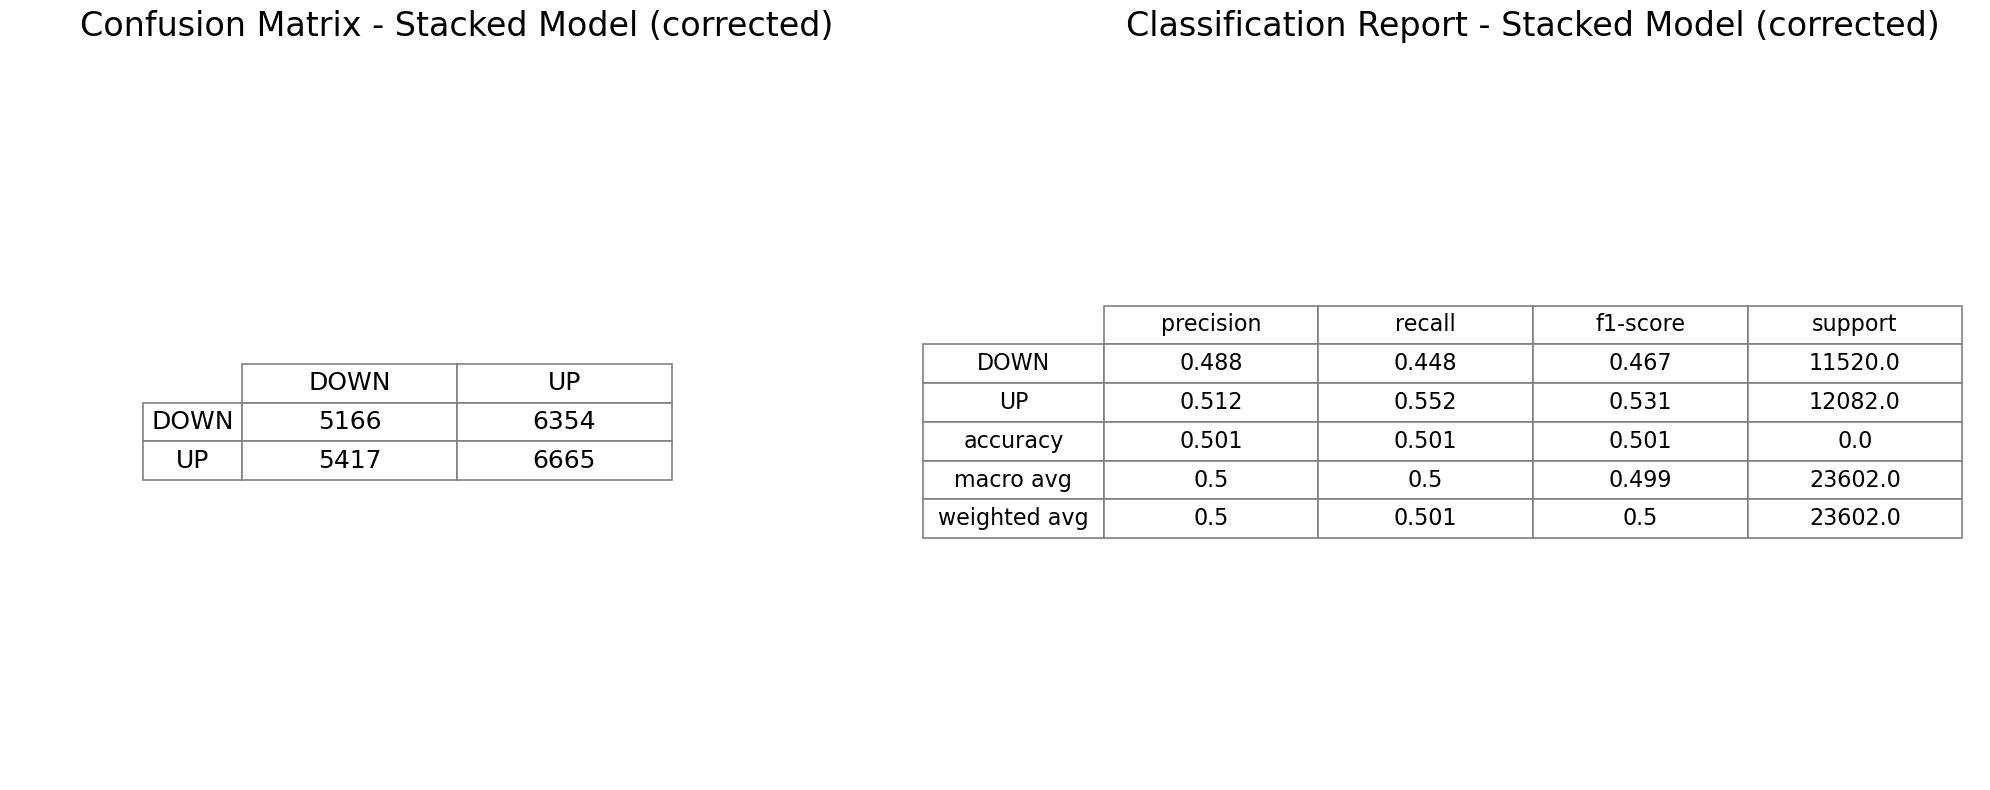

In [528]:
# display validation accuracy
print(f"Validation Accuracy: {meta_acc:.4f}")

# confusion matrix
meta_cm = confusion_matrix(y_test_time, meta_y_pred)
labels = sorted(merged_1day['target'].unique())
meta_cm_df = pd.DataFrame(meta_cm, index=labels, columns=labels)

# classification report
meta_cr = classification_report(y_test_time, meta_y_pred, output_dict=True)
meta_cr_df = pd.DataFrame(meta_cr).transpose()
for col in ['precision', 'recall', 'f1-score']:
    meta_cr_df[col] = meta_cr_df[col].round(3)
meta_cr_df['support'] = meta_cr_df['support'].astype(int)
meta_cr_df.rename(index={'0': 'DOWN', '1': 'UP'}, inplace=True)

# plot confusion matrix and classification report
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# confusion matrix on left
axes[0].axis('off')
table1 = axes[0].table(cellText=meta_cm_df.values,
                       rowLabels=meta_cm_df.index,
                       colLabels=meta_cm_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(meta_cm_df.columns)
)

table1.auto_set_font_size(False)
table1.set_fontsize(18)
table1.scale(1.2, 2.0)
for key, cell in table1.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[0].set_title('Confusion Matrix - Stacked Model (corrected)', fontsize=24, pad=20)

# classification report on right
axes[1].axis('off')

table2 = axes[1].table(cellText=meta_cr_df.values,
                       rowLabels=meta_cr_df.index,
                       colLabels=meta_cr_df.columns,
                       cellLoc='center',
                       loc='center',
                       rowLoc='center',
                       colLoc='center',
                       colWidths=[0.2]*len(meta_cr_df.columns)
)

table2.auto_set_font_size(False)
table2.set_fontsize(16)
table2.scale(1.2, 2.0)
for key, cell in table2.get_celld().items():
    cell.set_linewidth(1.2)
    cell.set_edgecolor('gray')
axes[1].set_title('Classification Report - Stacked Model (corrected)', fontsize=24, pad=20)

plt.tight_layout()
#plt.savefig('time_corrected_meta_confusion_and_classification_report.png', dpi=300,  bbox_inches='tight')
plt.show()

In [541]:
# Assess cumulative returns by picking most likely UPs daily

# create copy of merged_1day_test with results
meta_test_results = test_set_time.copy()
meta_test_results['prob_up'] = meta_y_proba

# add daily % return column
meta_test_results['daily_return_pct'] = ((meta_test_results['close'] - meta_test_results['prev_close']) / meta_test_results['prev_close']) * 100

# sort by date and predicted probability
meta_sorted_preds = meta_test_results.sort_values(by=['date', 'prob_up'], ascending=[True, False])

# apply threshold filter (keep only confident picks)
meta_sorted_preds = meta_sorted_preds[meta_sorted_preds['prob_up'] >= 0.6]

# get top 5 (or fewer) picks per day
meta_top5_daily = meta_sorted_preds.groupby('date').head(5)

# calculate average return for the top picks per day
meta_daily_avg_return = meta_top5_daily.groupby('date')['daily_return_pct'].mean().reset_index()
meta_daily_avg_return.rename(columns={'daily_return_pct': 'avg_top5_return_pct'}, inplace=True)

# compute cumulative return (compounded over time)
meta_daily_avg_return['cumulative_return_pct'] = (1 + meta_daily_avg_return['avg_top5_return_pct'] / 100).cumprod() - 1
meta_daily_avg_return['cumulative_return_pct'] *= 100  # back to percent

In [542]:
# Build S&P 500 comparison

# get S&P 500 data for the same date range
start_date_test = meta_daily_avg_return['date'].min()
end_date_test = meta_daily_avg_return['date'].max()
sp500_test = yf.download("^GSPC", start=start_date_test, end=end_date_test)
sp500_test.index = sp500_test.index.tz_localize(None)

# ensure index is datetime and trimmed to match your data
sp500_test = sp500_test[['Open', 'Close']]
sp500_test = sp500_test.reset_index()  # brings 'Date' into a column
sp500_test.rename(columns={'Date': 'date'}, inplace=True)  # match column name with daily_avg_return

# prepare the S&P 500 daily % returns and cumulative return
sp500_test['daily_return_pct'] = ((sp500_test['Close'] - sp500_test['Open']) / sp500_test['Open']) * 100
sp500_test['sp500_cum_return_pct'] = (1 + sp500_test['daily_return_pct'] / 100).cumprod() - 1
sp500_test['sp500_cum_return_pct'] *= 100

# ensure sp500 'date' is datetime type
sp500_test['date'] = pd.to_datetime(sp500_test['date'])

# flatten sp500 multi-level columns (if any)
sp500_test.columns = [col if isinstance(col, str) else col[0] for col in sp500_test.columns]

# merge with returns
meta_comparison = meta_daily_avg_return.merge(
    sp500_test[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

rf_test_comparison = rf_test_daily_avg_return.merge(
    sp500_test[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

cnn_test_comparison = cnn_test_daily_avg_return.merge(
    sp500_test[['date', 'sp500_cum_return_pct']],
    on='date',
    how='left'
)

[*********************100%***********************]  1 of 1 completed


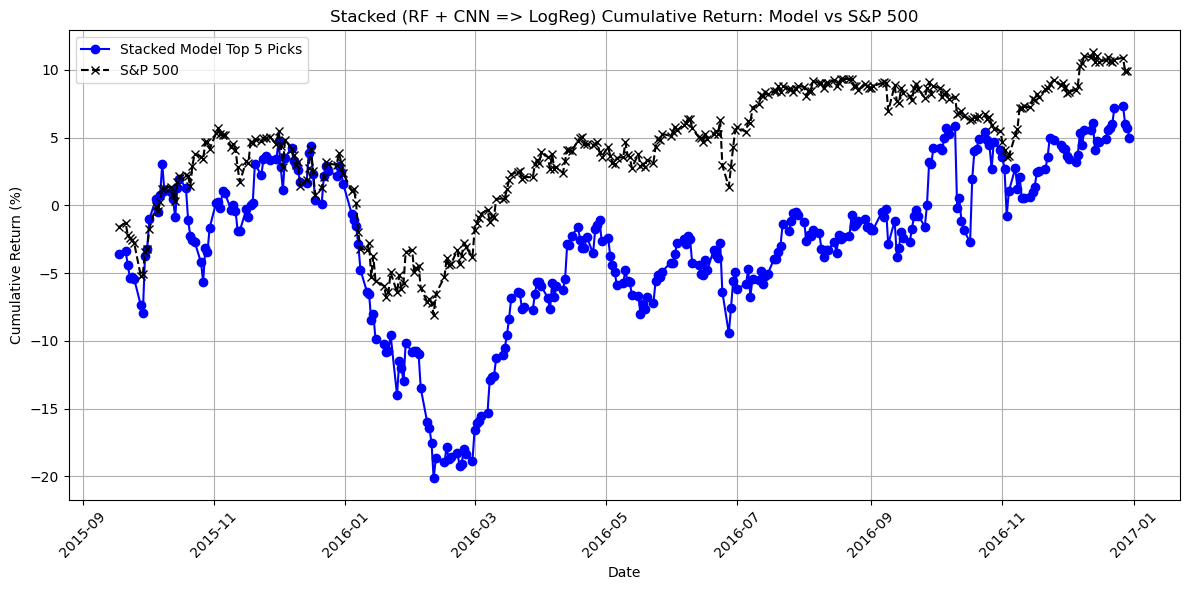

In [543]:
# plot stacked model returns and S&P 500 returns
plt.figure(figsize=(12, 6))
plt.plot(
    meta_comparison['date'], meta_comparison['cumulative_return_pct'],
    label='Stacked Model Top 5 Picks',
    color='blue', marker='o', linestyle='-')
plt.plot(
    meta_comparison['date'], meta_comparison['sp500_cum_return_pct'],
    label='S&P 500',
    color='black', marker='x', linestyle='--')

plt.title("Stacked (RF + CNN => LogReg) Cumulative Return: Model vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('time_corrected_meta_cumulative_return_comparison.png', format='png') 
plt.show()

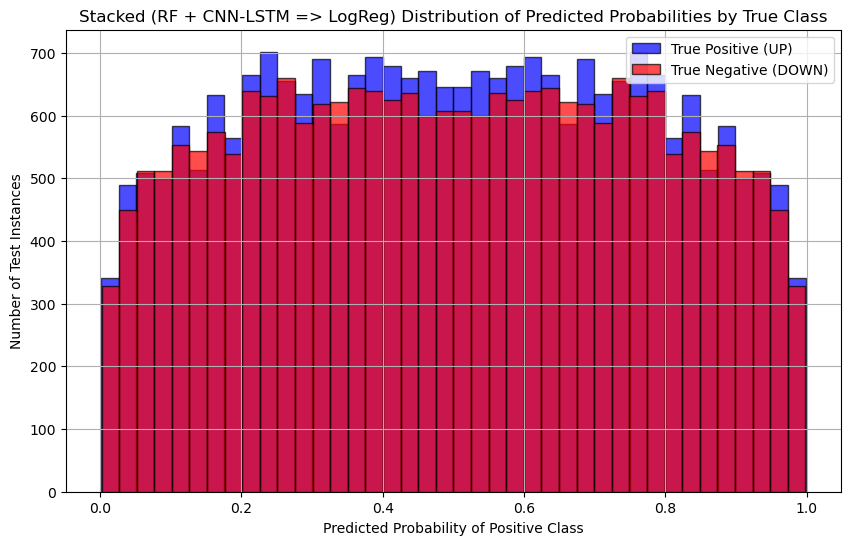

In [547]:
# plot distributions of predictions by true class
y_test_array = np.array(y_test_time)

# split the predicted probabilities based on true labels
meta_probs_positive = meta_probs[y_test_array == 1]
meta_probs_negative = meta_probs[y_test_array == 0]

meta_probs_positive = meta_probs_positive.flatten()
meta_probs_negative = meta_probs_negative.flatten()

# Now plot
plt.figure(figsize=(10, 6))
plt.hist(meta_probs_positive, bins=40, alpha=0.7, label='True Positive (UP)', color='blue', edgecolor='k')
plt.hist(meta_probs_negative, bins=40, alpha=0.7, label='True Negative (DOWN)', color='red', edgecolor='k')

plt.title('Stacked (RF + CNN-LSTM => LogReg) Distribution of Predicted Probabilities by True Class')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Number of Test Instances')
plt.legend()
plt.grid(True)
#plt.savefig('time_corrected_meta_prob_distribution_versus_true_class.png', format='png')
plt.show()

## Summary of Corrected Model Performances vs S&P 500

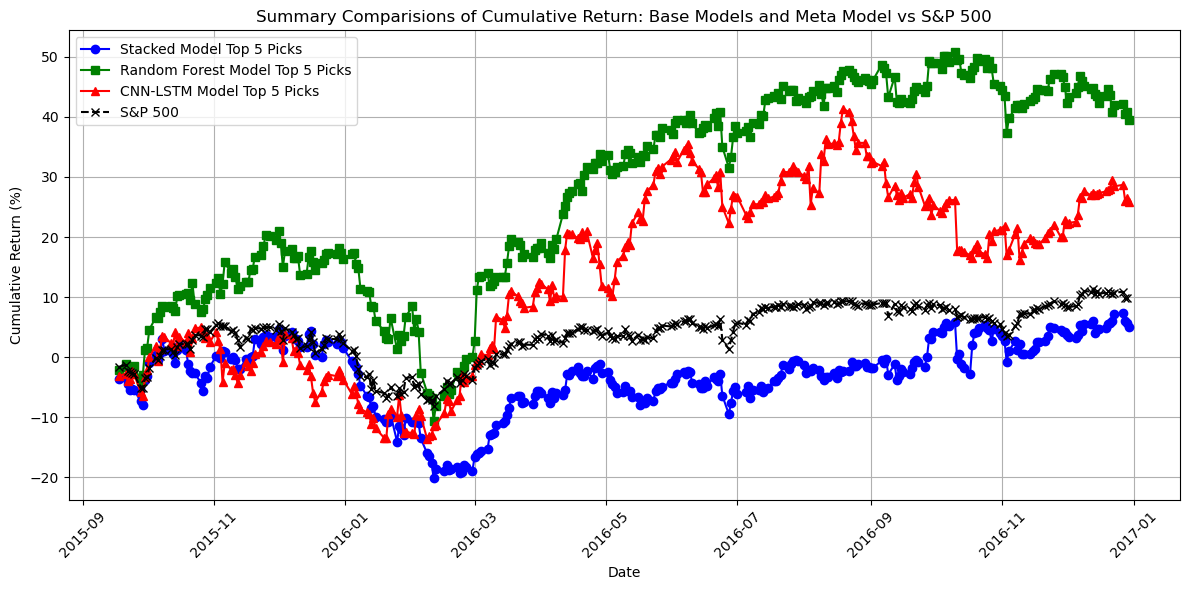

In [546]:
# plot stacked model, RF, and NN returns with S&P 500 returns
plt.figure(figsize=(12, 6))
plt.plot(
    meta_comparison['date'], meta_comparison['cumulative_return_pct'],
    label='Stacked Model Top 5 Picks',
    color='blue', marker='o', linestyle='-')
plt.plot(
    rf_test_comparison['date'], rf_test_comparison['cumulative_return_pct'],
    label='Random Forest Model Top 5 Picks',
    color='green', marker='s', linestyle='-')
plt.plot(
    cnn_test_comparison['date'], cnn_test_comparison['cumulative_return_pct'],
    label='CNN-LSTM Model Top 5 Picks',
    color='red', marker='^', linestyle='-')
plt.plot(
    meta_comparison['date'], meta_comparison['sp500_cum_return_pct'],
    label='S&P 500',
    color='black', marker='x', linestyle='--')

plt.title("Summary Comparisions of Cumulative Return: Base Models and Meta Model vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig('time_corrected_summary_cumulative_return_comparison.png', format='png') 
plt.show()

In [550]:
from graphviz import Digraph

In [551]:
def create_cnn_lstm_diagram():
    dot = Digraph(comment='Hybrid CNN-LSTM Architecture')

    dot.attr(rankdir='LR')  # left to right layout

    dot.node('Input', 'Input Layer\n(shape=40)')
    dot.node('Embed', 'Embedding Layer\n(input_dim=10000,\noutput_dim=100)')
    dot.node('Conv1D', 'Conv1D\n(filters=64,\nkernel=3,\nactivation=ReLU)')
    dot.node('Pool', 'MaxPooling1D\n(pool_size=2)')
    dot.node('LSTM', 'LSTM\n(units=64)')
    dot.node('Dropout', 'Dropout\n(rate=0.5)')
    dot.node('Dense', 'Dense\n(units=64,\nactivation=ReLU,\nL2=0.01)')
    dot.node('Output', 'Output\n(Dense, sigmoid)')

    # Connect the layers
    dot.edges([
        ('Input', 'Embed'),
        ('Embed', 'Conv1D'),
        ('Conv1D', 'Pool'),
        ('Pool', 'LSTM'),
        ('LSTM', 'Dropout'),
        ('Dropout', 'Dense'),
        ('Dense', 'Output')
    ])

    return dot

# Create and render the diagram
cnn_lstm_diagram = create_cnn_lstm_diagram()
cnn_lstm_diagram.render('cnn_lstm_architecture', format='png', cleanup=False)
cnn_lstm_diagram.view()

'cnn_lstm_architecture.pdf'

# Output function refactored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)

In [553]:

def evaluate_classifier(model, X_val, y_val, labels=None, threshold=0.5, title_suffix='', save_path=None, show_plot=True):
    """
    Evaluates a binary classification model by displaying or saving:
      - Confusion matrix
      - Classification report
      - ROC curve with AUC

    Parameters:
        model: Trained classifier with predict_proba method.
        X_val: Validation features.
        y_val: True validation labels.
        labels: Optional list of class labels. If None, derived from y_val.
        threshold: Decision threshold for positive class.
        title_suffix: Custom suffix for plot titles.
        save_path: If provided (e.g., 'results.png'), saves the plot instead of displaying it.

    Returns:
        cm_df: Confusion matrix as pandas DataFrame.
        cr_df: Classification report as pandas DataFrame.
        accuracy: Validation accuracy as float.
        auc_score: AUC score as float.
    """
    # Predict probabilities and apply threshold
    probs = model.predict_proba(X_val)
    y_proba = probs[:, 1]
    y_pred = (y_proba > threshold).astype("int32")

    # Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    if labels is None:
        labels = sorted(np.unique(y_val))
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Classification report
    cr = classification_report(y_val, y_pred, output_dict=True)
    cr_df = pd.DataFrame(cr).transpose()
    for col in ['precision', 'recall', 'f1-score']:
        cr_df[col] = cr_df[col].round(3)
    cr_df['support'] = cr_df['support'].astype(int)
    cr_df.rename(index={'0': 'DOWN', '1': 'UP'}, inplace=True)

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc_score = roc_auc_score(y_val, y_proba)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))

    # Confusion Matrix
    axes[0].axis('off')
    table1 = axes[0].table(cellText=cm_df.values,
                           rowLabels=cm_df.index,
                           colLabels=cm_df.columns,
                           cellLoc='center',
                           loc='center',
                           rowLoc='center',
                           colLoc='center',
                           colWidths=[0.2]*len(cm_df.columns))
    table1.auto_set_font_size(False)
    table1.set_fontsize(18)
    table1.scale(1.2, 2.0)
    for key, cell in table1.get_celld().items():
        cell.set_linewidth(1.2)
        cell.set_edgecolor('gray')
    axes[0].set_title(f'Confusion Matrix {title_suffix}', fontsize=24, pad=20)

    # Classification Report
    axes[1].axis('off')
    table2 = axes[1].table(cellText=cr_df.values,
                           rowLabels=cr_df.index,
                           colLabels=cr_df.columns,
                           cellLoc='center',
                           loc='center',
                           rowLoc='center',
                           colLoc='center',
                           colWidths=[0.2]*len(cr_df.columns))
    table2.auto_set_font_size(False)
    table2.set_fontsize(16)
    table2.scale(1.2, 2.0)
    for key, cell in table2.get_celld().items():
        cell.set_linewidth(1.2)
        cell.set_edgecolor('gray')
    axes[1].set_title(f'Classification Report {title_suffix}', fontsize=24, pad=20)

    # ROC Curve
    axes[2].plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
    axes[2].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate', fontsize=14)
    axes[2].set_ylabel('True Positive Rate', fontsize=14)
    axes[2].set_title(f'ROC Curve {title_suffix}', fontsize=24, pad=20)
    axes[2].legend(loc='lower right', fontsize=14)
    axes[2].grid(True)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    if show_plot:
        plt.show()
    else:
        plt.close()

    return cm_df, cr_df, accuracy, auc_score
